In [79]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import matplotlib.pyplot as plt
import re
import pandas as pd
from statsmodels.stats.outliers_influence import summary_table
from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter

from collections import Counter, defaultdict

import statsmodels.api as sm
import seaborn as sns
import sqlite3
import pickle
from scipy import stats
import json
from datetime import datetime

%matplotlib inline

In [122]:
def jaccard_similarity(a, b):
    intersection = set(a).intersection(set(b))
    union = set(a).union(set(b))
    return len(intersection)/len(union)

In [2]:
from geopy.geocoders import Nominatim
geolocator_nominatim = Nominatim()

In [3]:
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
from geopy.exc import GeocoderTimedOut, GeocoderQueryError
from geopy.distance import vincenty

In [83]:
import googlemaps
gmaps_key = json.load(open('/Users/spardy/.config/OAUTHS/google.json'))['KEY']
gmaps = googlemaps.Client(key=gmaps_key)

In [4]:
def lookup_coords(loc, retries=2):
    i = 0
    while i < retries:
        try:
            loc_res = geolocator.geocode(loc)
            return loc_res
        except (GeocoderTimedOut, GeocoderQueryError):
            i += 1
     

In [5]:
def running_median(x, width, upper=90, lower=10):
    if width % 2 == 0:
        width += 1
    
    N = width // 2
    
    def make_window(x, i):
        ln = len(x)
        start = i - N if i > N else 0
        end = i + N if i < ln - N else ln
        return x[start:end]
    
    medians = np.empty_like(x)
    upper_perc = np.empty_like(x)
    lower_perc = np.empty_like(x)
    
    for i in range(len(x)):
        window = make_window(x, i)
        medians[i] = np.median(window)
        upper_perc[i] = np.percentile(window, upper)
        lower_perc[i] = np.percentile(window, lower)
        
    return medians, upper_perc, lower_perc

## AAS Has changed their webpage and no longer hold all this data

In [147]:
headers = {
    'User-Agent': '',
}

In [105]:
baseurl = 'https://jobregister.aas.org/archives/'

In [80]:
url = 'https://jobregister.aas.org/archives/back_issues'
r = requests.get(url, headers=headers)
c = r.content
soup = BeautifulSoup(c)

/usr/local/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [103]:
jobs_each_year = soup.find('table', {'class': 'TableBorders'}).find_all('tr')[1:]

In [107]:
jobs_each_year = []  # to prevent running
full_df = None
for jobs_this_year in jobs_each_year:
    entries = jobs_this_year.find_all('td')
    year = entries[0].text
    for entry in entries[1:]:
        month = entry.find('a').text
        job_page_url = baseurl + entry.find('a').attrs['href'] 
        print(job_page_url, month, year)
        
        #scrape job page
        
        job_r = requests.get(job_page_url, headers=headers)
        job_c = job_r.content
        job_soup = BeautifulSoup(job_c)
        
        jobs1 = job_soup.find_all("tr", {"class": "JR_Tablle_Row_Color_1"})
        jobs2 = job_soup.find_all("tr", {"class": "JR_Tablle_Row_Color_2"})
        jobs = jobs1+jobs2
        Njobs = len(jobs)
        
        jobs_url = np.empty(Njobs, dtype=object)
        jobs_num = np.empty(Njobs, dtype=int)
        jobs_name = np.empty(Njobs, dtype=object)
        jobs_location = np.empty(Njobs, dtype=object)
        jobs_posted_date = np.empty(Njobs, dtype=object)
        
        for i, job in enumerate(jobs):
            entries = job.find_all('td')
            job_link = entries[0].find('a')

            jobs_url[i] = job_link.attrs['href']
            jobs_num[i] = int(job_link.text[1:])
            jobs_name[i] = entries[1].find('a').text
            jobs_location[i] = entries[2].text
            jobs_posted_date[i] = entries[3].text
            
        data = np.vstack((jobs_url, jobs_num, jobs_name, jobs_location, jobs_posted_date)).T
        
        df_ = pd.DataFrame(data, columns=['url', 'job_number', 'position', 'location', 'posted'])
        
        conn = sqlite3.connect("AAS_jobs.db")
        df_.to_sql(month+year, conn, if_exists="replace")
        conn.close()
        
        if full_df is None:
            full_df = df_
        else:
            full_df = full_df.append(df_)


https://jobregister.aas.org/archives/issue?year=2003&month=1 January 2003


/usr/local/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


https://jobregister.aas.org/archives/issue?year=2003&month=2 February 2003
https://jobregister.aas.org/archives/issue?year=2003&month=3 March 2003
https://jobregister.aas.org/archives/issue?year=2003&month=4 April 2003
https://jobregister.aas.org/archives/issue?year=2003&month=5 May 2003
https://jobregister.aas.org/archives/issue?year=2003&month=6 June 2003
https://jobregister.aas.org/archives/issue?year=2003&month=7 July 2003
https://jobregister.aas.org/archives/issue?year=2003&month=8 August 2003
https://jobregister.aas.org/archives/issue?year=2003&month=9 September 2003
https://jobregister.aas.org/archives/issue?year=2003&month=10 October 2003
https://jobregister.aas.org/archives/issue?year=2003&month=11 November 2003
https://jobregister.aas.org/archives/issue?year=2003&month=12 December 2003
https://jobregister.aas.org/archives/issue?year=2004&month=1 January 2004
https://jobregister.aas.org/archives/issue?year=2004&month=2 February 2004
https://jobregister.aas.org/archives/issue?y

https://jobregister.aas.org/archives/issue?year=2012&month=6 June 2012
https://jobregister.aas.org/archives/issue?year=2012&month=7 July 2012
https://jobregister.aas.org/archives/issue?year=2012&month=8 August 2012
https://jobregister.aas.org/archives/issue?year=2012&month=9 September 2012
https://jobregister.aas.org/archives/issue?year=2012&month=10 October 2012
https://jobregister.aas.org/archives/issue?year=2012&month=11 November 2012
https://jobregister.aas.org/archives/issue?year=2012&month=12 December 2012
https://jobregister.aas.org/archives/issue?year=2013&month=1 January 2013
https://jobregister.aas.org/archives/issue?year=2013&month=2 February 2013
https://jobregister.aas.org/archives/issue?year=2013&month=3 March 2013
https://jobregister.aas.org/archives/issue?year=2013&month=4 April 2013
https://jobregister.aas.org/archives/issue?year=2013&month=5 May 2013
https://jobregister.aas.org/archives/issue?year=2013&month=6 June 2013
https://jobregister.aas.org/archives/issue?year=

## Load full posting for available archives

In [6]:
headers = {
    'User-Agent': '',
}

In [34]:
job_data = {}

In [37]:
base_url = 'https://jobregister.aas.org/'

archive_urls = ["/jobs/archive/2017/7",
 "/jobs/archive/2017/6",
 "/jobs/archive/2017/5",
 "/jobs/archive/2017/4",
 "/jobs/archive/2017/3",
 "/jobs/archive/2017/2",
 "/jobs/archive/2017/1",
 "/jobs/archive/2016/12",
 "/jobs/archive/2016/11",
 "/jobs/archive/2016/10",
 "/jobs/archive/2016/9",
 "/jobs/archive/2016/8"]

for archive_url in archive_urls:
    job_data[archive_url] = {}
    
    url = base_url + archive_url
    r = requests.get(url, headers=headers)
    c = r.content
    soup = BeautifulSoup(c)
    
    jobs = soup.find_all('td', {'class': 'jobs_hash_id'})
    for job in jobs:
        href = job.find('a')['href']
        r_job = requests.get(base_url+href, headers=headers)
        c_job = r_job.content
        soup_job = BeautifulSoup(c_job)
        _data = soup_job.find_all('fieldset')
        job_data[archive_url][href] = _data
        

/usr/local/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [69]:
def get_contents_of_fields(field_sets):
    info = {}
    for field_set in field_sets:
        fields = field_set.find_all('div', {'class': 'field'})
        for field in fields:
            label = field.find('div', {'class', 'field-label'})
            contents = field.find('div', {'class', 'field-item'})
            info[label.text] = contents.text
    return info


In [73]:
job_data_fields = [get_contents_of_fields(_data) for _data1 in job_data.values() for _data in _data1.values()]

In [91]:
for _job_data_fields in job_data_fields:
    if 'loc' not in _job_data_fields:
        loc = lookup_coords(_job_data_fields['Institution/Company:\xa0'])
        if loc is None:
            print("No location found for: {:s}".format(_job_data_fields['Institution/Company:\xa0']))
        else:
            _job_data_fields['loc'] = loc

No location found for: 
No location found for: 
No location found for: Center for Theoretical Physics, Polish Academy of Sciences
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No loc

No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: Unniversity of the Pacific
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: NCCR PlanetS
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: LERMA, Observatoire de Paris / IAP
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location found for: 
No location foun

In [112]:
#for _job_data_fields in job_data_fields:
#    if 'loc' in _job_data_fields:
#        location_coordinates[_job_data_fields['Institution/Company:\xa0']] = _job_data_fields['loc']

In [77]:
#pickle.dump(job_data_fields, open('Data/job_archives.pl', 'wb'))

## Load from db

In [116]:
full_df = None

conn = sqlite3.connect("AAS_jobs.db")
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
for table_name in tables:
    table_name = table_name[0]
    if table_name != 'test':
        df_ = pd.read_sql_query("SELECT * from %s" % table_name, conn)
        
        if full_df is None:
            full_df = df_
        else:
            full_df = full_df.append(df_)
conn.close()

In [246]:
full_df.shape

(18355, 8)

In [247]:
full_df = full_df.drop_duplicates(subset=('job_number', 'location'))

In [248]:
full_df.shape

(11709, 8)

In [249]:
months = [datetime.strptime(key, '%b %Y') for key in full_df.groupby('posted').count()['url'].keys()]
counts = full_df.groupby('posted').count()['url'].values

In [250]:
for i, row in enumerate(full_df.iterrows()):
    loc = row[1][3]
    pos = row[1][2]
    url = row[1][0]
    if 'Illinois' in loc:
        print(i, row)
        #print(pos, loc, url)


501 (122, index                                                       122
url                                     ../job_view?JobID=21603
job_number                                                21603
position      Multiple Post Doctoral positions in Cosmology ...
location                                 University of Illinois
posted                                                 Dec 2003
Country                                                     USA
Year                                                       2003
Name: 122, dtype: object)
5467 (43, index                                                        43
url                                     ../job_view?JobID=37119
job_number                                                37119
position      Illinois-Paris Fellow in Computational/Theoret...
location               University of Illinois at Urbana-Champai
posted                                                 Aug 2010
Country                                                   

In [300]:
for loc, url in zip(full_df['location'], full_df['url']):
    if 'Chicago' in loc:
        print(loc, url)

University of Chicago ../job_view?JobID=20364
University of Chicago, Enrico Fermi Inst ../job_view?JobID=20376
University of Chicago ../job_view?JobID=20364
University of Chicago, Enrico Fermi Inst ../job_view?JobID=20376
University of Chicago ../job_view?JobID=20706
The University of Chicago ../job_view?JobID=20499
The University of Chicago ../job_view?JobID=20499
University of Chicago ../job_view?JobID=20706
The University of Chicago ../job_view?JobID=21045
The University of Chicago ../job_view?JobID=20499
The University of Chicago ../job_view?JobID=21042
University of Chicago ../job_view?JobID=20706
The University of Chicago ../job_view?JobID=21414
The University of Chicago ../job_view?JobID=21639
The University of Chicago ../job_view?JobID=21642
The University of Chicago ../job_view?JobID=21639
The University of Chicago ../job_view?JobID=21642
The University of Chicago ../job_view?JobID=21639
The University of Chicago ../job_view?JobID=21642
University of Chicago Press ../job_view?

In [251]:
#pure binned yearly avg
year_bins = np.zeros((14, 2))
for month, count in zip(months, counts):
    bin_id = month.year % 2003
    if bin_id < 14:
        year_bins[bin_id, 0] += count
        year_bins[bin_id, 1] += 1
        
year_avg = year_bins[:, 0]/year_bins[:, 1]
years = [datetime.strptime(str(y), '%Y') for y in range(2003, 2017)]

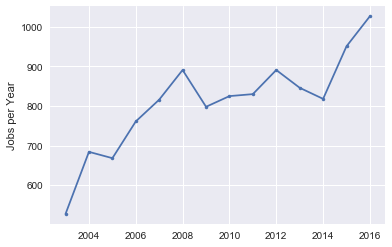

In [252]:
fig, axis = plt.subplots(1)
axis.plot(years, year_bins[:, 0], '.', linestyle='-')
axis.set_ylabel('Jobs per Year')

In [253]:
for year, tot in zip(years, year_bins[:, 0]):
    print(year, tot)

2003-01-01 00:00:00 527.0
2004-01-01 00:00:00 684.0
2005-01-01 00:00:00 668.0
2006-01-01 00:00:00 761.0
2007-01-01 00:00:00 816.0
2008-01-01 00:00:00 891.0
2009-01-01 00:00:00 798.0
2010-01-01 00:00:00 825.0
2011-01-01 00:00:00 830.0
2012-01-01 00:00:00 891.0
2013-01-01 00:00:00 846.0
2014-01-01 00:00:00 818.0
2015-01-01 00:00:00 951.0
2016-01-01 00:00:00 1027.0


In [254]:
ms = np.argsort(months)
avg_ct, upper_ct, lower_ct = running_median(counts[ms], 12, upper=75, lower=25)

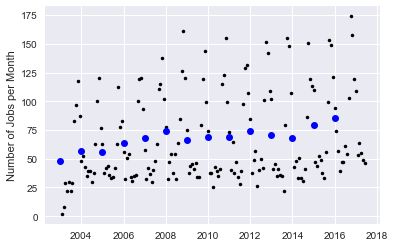

In [46]:
fig, axis = plt.subplots(1)
axis.plot(months, counts, 'k.')
axis.set_ylabel('Number of Jobs per Month')
axis.plot(years, year_avg, 'bo')


In [44]:
with open('/Users/spardy/Code/Web/Blog/resources/AASJobTrendMonthly.csv', 'w') as f:
    f.write('Year,Month,Total\n')
    for date_, num_ in zip(months, counts):
        y_ = date_.year
        m_ = date_.month
        f.write("{:d},{:d},{:d}\n".format(y_, m_, int(num_)))

In [255]:
months_folded = [d.replace(year=2000) for d in months]

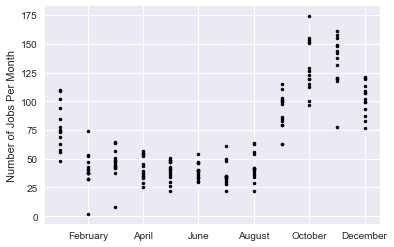

In [48]:
fig, axis = plt.subplots(1)
axis.plot(months_folded, counts, 'k.')
axis.xaxis.set_major_formatter(DateFormatter('%B'))
axis.set_ylabel('Number of Jobs Per Month')

In [199]:
full_df['position'].map(lambda x: 'postdoc' in x.lower())

8016

In [201]:
sum(full_df['position'].map(lambda x: 'phd' in x.lower()))

564

In [109]:
location_coordinates = pickle.load(open('job_locations.pl', 'rb'))

In [51]:
location_count = Counter(full_df['location'])

In [52]:
close_groups = []
for loc1, loc_res1 in location_coordinates.items():
    
    if loc1 in [i for ai in close_groups for i in ai['names']]:
        continue
    
    close_group = {}
    close_group['names'] = [loc1]
    close_group['loc'] = loc_res1
    close_group['count'] = location_count[loc1]
    
    for loc2, loc_res2 in location_coordinates.items():
        
        if loc1 == loc2:
            continue
        
        if loc2 in [i for ai in close_groups for i in ai['names']]:
            continue
        
        p1 = (loc_res1.latitude,
              loc_res1.longitude)

        p2 = (loc_res2.latitude,
              loc_res2.longitude)
        
        if vincenty(p1, p2).kilometers < 2:
            close_group['names'].append(loc2)
            close_group['count'] += location_count[loc2]
            
    if len(close_group) > 1:
        close_groups.append(close_group)
            

In [54]:
with open('/Users/spardy/Code/Web/Blog/resources/AAS_job_locs.csv', 'w') as f:
    f.write("Lat,Lon,Count,Name\n")
    for close_group in close_groups:
        f.write("{:3.6f},{:3.6f},{:d},{:s}\n".format(close_group['loc'].latitude,
                                                close_group['loc'].longitude,
                                                close_group['count'],
                                                close_group['names'][0].replace(',','')))

In [ ]:
#location_coordinates = {}

In [153]:
for loc in full_df['location'].unique():
    if loc not in location_coordinates:
        sim = np.zeros(len(location_coordinates))
        for i, loc_key in enumerate(location_coordinates.keys()):
            sim[i] = jaccard_similarity(loc, loc_key)
            
        if max(sim) > 0.8:
            loc_res = list(location_coordinates.values())[np.argmax(sim)]
        else:
            loc_res = lookup_coords(loc)
        
        if loc_res is not None:
            location_coordinates[loc] = loc_res
        else:            
            print(max(sim), "No results found for - {:s}".format(loc))
        

0.761904761905 No results found for - Joint Astronomy Centre (Research Corpora
0.75 No results found for - Chandra X-Ray Center, Smithsonian Astrop
0.733333333333 No results found for - Canadian universities listed in text
0.0 No results found for - 
0.777777777778 No results found for - Danish Space Research Institute
0.76 No results found for - Max-Planck-Society for the Advancement o
0.791666666667 No results found for - Swinburne University Centre for Astrophy
0.571428571429 No results found for - C.A.R.A./W.M. Keck Obsv.
0.730769230769 No results found for - UCSC Astronomy Department / UCO Lick Obs
0.75 No results found for - Attn: Fortner Research Fellowships in Th
0.72 No results found for - TIARA, Academia Sinica and National Tsin
0.666666666667 No results found for - Jodrell Bank Observatory and other ANGLE
0.722222222222 No results found for - Positions at several institutes in Germa
0.68 No results found for - CELT Development Corporation - Thirty Me
0.5 No results found for

GeocoderQuotaExceeded: The given key has gone over the requests limit in the 24 hour period or has submitted too many requests in too short a period of time.

In [256]:
countries = []
for loc in full_df['location']:
    if loc in location_coordinates:
        countries.append(location_coordinates[loc].address.split(',')[-1])
    else:
        countries.append(None)

full_df['Country'] = pd.Series(countries, index=full_df.index)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [257]:
def get_year(entry):
    #print(ind)
    return entry.split(' ')[1]

full_df['Year'] = pd.Series(full_df['posted'].apply(get_year), index=full_df.index)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
def is_us(series):
    
    def _is_us(entry):
        if entry is not None:
            return entry.lstrip() == 'USA'
        else:
            return False
    
    return series.apply(_is_us)


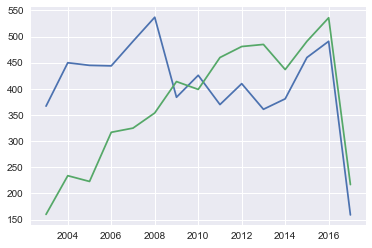

In [259]:
plt.plot(full_df.groupby('Year')['Country'].apply(lambda s: sum(is_us(s))))
plt.plot(full_df.groupby('Year')['Country'].apply(lambda s: sum(~is_us(s))))


In [260]:
us_jobs = full_df.groupby('Year')['Country'].apply(lambda s: sum(is_us(s)))
non_us_jobs = full_df.groupby('Year')['Country'].apply(lambda s: sum(~is_us(s)))

In [262]:
with open('/Users/spardy/Code/Web/Blog/resources/AASJobTrendYearly.csv', 'w') as f:
    f.write('Year,Avg,Total,US,NonUS\n')
    for y_, avg_, tot_, us_, non_ in zip([year.year for year in years], year_avg, year_bins[:, 0],
                              us_jobs, non_us_jobs):
        f.write("{:d},{:2.3f},{:d},{:d},{:d}\n".format(y_, avg_, int(tot_), us_, non_))

In [121]:
#pickle.dump(location_coordinates, open('job_locations.pl', 'wb'))

In [219]:
def find_field(pos):
    pos_l = pos.lower()
    if ' in ' in pos_l:
        return pos_l[pos_l.find(' in ')+4:]
    else:
        return None

unique_fields = full_df['position'].map(find_field).unique()

In [220]:
for field in unique_fields:
    print(field)

None
observational astronomy
computational astrophysics
3d spectroscopy
grb astrophysics with swift
astrophysics
stellar populations
physics and astronomy
x-ray astronomy
extragalactic astronomy and cosmology
observatinal cosmology and/or submillimeter instrumentation
theoretical astrophysics
high-energy astrophysics
antarctic submillimeter astronomy
astrophysics and cosmology
observational molecular line astronomy
astronomy and astrophysics
gamma-ray astrophysics
cometary science
experimental astronomy
astronomy
theoretical cosmology & particle astrophysics
observational astrophysics
numerical hydrodynamics of wind-blown nebulae around massive stars/supernova remnants
galaxy formation and evolution
gamma-ray detector development and experimental
theoretical astrophysics/cosmology
millimetre- wave interferometry
space sciences - nasa - goddard space flight center
the astromomy department
physics
extragalactic astronomy
protostellar disk evolution
infrared extragalactic astronomy
infrar

space physics, department of physics and space sciences 
astronomy and astrophysics at shanghai jiao tong university
 non-accelerator he
software engineering
agn/quasar narrow line region emission line imaging and integral field spectroscopy
cosmology and large scale structures  at ias, orsay
observational early universe studies of metal-poor stars and chemical evolution
extragalactic astronomy and observational cosmology at shanghai jiao tong university
cosmology & astrophysics
supernova studies 
experimental astrophysics on exoplanets
multiwavelength studies of nearby galaxies
observational extragalactic astrophysics - leibniz institute for astrophysics potsdam (aip)
galaxy formation modeling at the university of chicago
all fields in astrophysics
planetary science, department of physics and space sciences
“space science instrumentation” at the institut d'astrophysique spatiale and univ. paris-sud  (orsay, france)
astronomy with specialisation in physics of planetary systems ufv-pa 2

In [97]:
conn = sqlite3.connect("AAS_jobs.db")
df1 = pd.read_sql("SELECT * FROM TEST", conn)
conn.close()